In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import  FeatureUnion
from sklearn.preprocessing import FunctionTransformer
import gensim
from gensim.models.fasttext import FastText 
import numpy as np
import pandas as pd
import re


from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline




/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train = pd.read_csv("train.csv")

train.head()

,ID,Text,Label
0,ID_AASHwXxg,Mwangonde: Khansala wachinyamata Akamati achi...,POLITICS
1,ID_AGoFySzn,MCP siidakhutire ndi kalembera Chipani cha Ma...,POLITICS
2,ID_AGrrkBGP,Bungwe la MANEPO Lapempha Boma Liganizire Anth...,HEALTH
3,ID_AIJeigeG,Ndale zogawanitsa miyambo zanyanya Si zachile...,POLITICS
4,ID_APMprMbV,Nanga wapolisi ataphofomoka? Masiku ano sichi...,LAW/ORDER


In [ ]:
train.shape

(1436, 3)

In [ ]:
train.Text[6]

'Kwaya ya St. James Chilomoni Yakwanitsa Zaka 40 Wolemba: Sylvester Kasitomu wp-content/uploads/2019/09/chilomoni.jpg" alt="" width="427" height="391" />Tchalitchi la St. James Chilomoni ku Blantyre Kwaya ya St. James ya m`parish ya Chilomoni mu arkdayosizi ya Blantyre yayamikira mamembala ake omwe akhala akutumikira mu kwayayi kwa nthawi yaitali kamba ka kakudzipereka kwao potukula maimbidwe mu kwayayi. \nWapampando wa kwayayi a Ezekiel Lokote ndiwo alankhula izi pa mwambo wa msembe ya ukaristia yothokoza mulungu kuti kwayayi yakwanitsa zaka makumi anayi (40) chiyikhazikitsireni. \nIwo ati mamembalawa achita zazikulu mu kwayayi kwa nthawi yaitali zomwe ati zathandiza kwambiri potuluka mayimbidwe a kwayayi. \nIfeyo tinachiona cha nzeru kuti tikonze mwambowu pofuna kuwathokoza mamemba athu kaamba ka ntchito yomwe agwira poonetsetsa kuti mayimbidwe mukwayayi akhalepo kwa zaka 40 zapitazi ena mwa mamembalawa akwanitsa zaka 30 akuimbira mulungu mukwayayi zomwe ndizonyaditsa Polankhulapo mm

In [ ]:
test = pd.read_csv("test.csv")
test.head(10)

,ID,Text
0,ID_ADHEtjTi,Abambo odzikhweza akuchuluka Kafukufuku wa ap...
1,ID_AHfJktdQ,Ambuye Ziyaye Ayamikira Aphunzitsi a Tilitonse...
2,ID_AUJIHpZr,Anatcheleza: Akundiopseza a gogo wanga Akundi...
3,ID_AUKYBbIM,Ulova wafika posauzana Adatenga digiri ya uph...
4,ID_AZnsVPEi,"Dzombe kukoma, koma Kuyambira makedzana, pant..."
5,ID_AcEmtLNf,Papa Watsiriza Ulendo Wake wa Nambala 32 Mtsog...
6,ID_AeOXSXRV,MCP yakhumudwa ndi kasankhidwe ka nduna Chipa...
7,ID_AgyQFeQn,"Asemphana pankhani ya malata, simenti sabusid..."
8,ID_AjOcippL,Boma lapempha amalawi adekhe pa za mathanyula...
9,ID_AjzKuqko,Zipani zilonjeza kampeni yotentha Tatulutsa k...


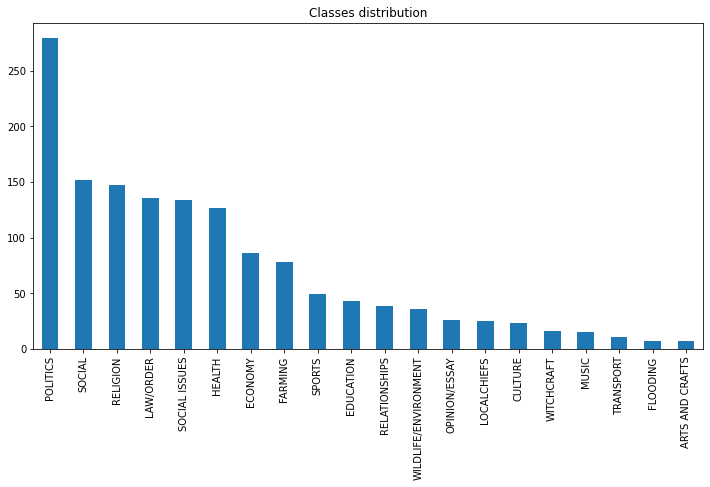

In [ ]:
train.Label.value_counts().plot.bar(figsize=(12, 6))
plt.title('Classes distribution');

In [ ]:
def preprosses_text(doc):
  # remove punctuation signs and multiple spaces
  regex_punc = re.compile('[%s]'%re.escape('.,!?'))
  doc = re.sub( regex_punc, ' ',doc)
  doc = doc.strip().lower() 
  regex_seq_spaces = re.compile(' {2,}')
  doc = re.sub( regex_seq_spaces, ' ',doc)
  return doc

  
train['text'] = train.Text.apply(lambda x: [i for i in preprosses_text(x).split() if len(i) > 1])
test['text'] = test.Text.apply(lambda x: [i for i in preprosses_text(x).split() if len(i) > 1])

In [ ]:
%%time
model = FastText(train.text.to_list() + test.text.to_list() , size=60, window=30, min_count=1, workers=12, iter=20, sg=1, bucket=400_000)
model.save('ft.model')

CPU times: user 32min 32s, sys: 2.77 s, total: 32min 35s
Wall time: 16min 47s


In [ ]:
def word_averaging(wv, words):
    mean = np.zeros((wv.vector_size,))
    
    for word in words:
        mean += wv.get_vector(word)

    mean = gensim.matutils.unitvec(mean)
    return mean

In [ ]:
%%time

union = FeatureUnion([
    ("char15", TfidfVectorizer(ngram_range =(1,5), analyzer='char_wb',stop_words=['ndi'],max_df = 0.2 ,min_df = 0.0 , 
                             max_features = 10000)),
    ("word12", TfidfVectorizer(ngram_range =(1,2), stop_words=['ndi'], max_df = 0.15 ,min_df = 0.01 ,
                             max_features = 5000)),
                      
                      ('fast_vec', FunctionTransformer(lambda df: df.apply(lambda x: word_averaging(model.wv,[i for i in preprosses_text(x).split() if len(i) > 1])).tolist(),
                                              validate=False)),
                                          
                      
                      ])
pipe = Pipeline([
    ('feats', union),
    ('clf',LogisticRegression( C = 5,solver = 'liblinear',class_weight='balanced'))
    
])


res = cross_val_score(pipe, train['Text'],train['Label'],
                            cv=StratifiedKFold(5, 
                                   shuffle=True, 
                                   random_state=777))
print(res,'\n mean:{:.3f} std :{:.3f}'.format(res.mean(),res.std()))

[0.62847222 0.65156794 0.65505226 0.67944251 0.66202091] 
 mean:0.655 std :0.017
CPU times: user 1min 31s, sys: 18.2 s, total: 1min 50s
Wall time: 1min 29s


In [ ]:
pipe.fit( train['Text'],train['Label'])

test.loc[:,"Label"] = pipe.predict(test['Text'])

test[['ID','Label']].to_csv("subww_bal.csv",index=False) 

#score 0.654838709677419 on private leaderboard